In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from collections import Counter

% matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.pipeline import Pipeline

# loading data and preprocessing

In [2]:
voxels = pd.read_csv("fszstatcope2_nvoxels_nz.csv", index_col=0)
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == voxels.index)) #should be 1.0
voxels_g27 = voxels.iloc[:, (voxels.iloc[1,:] > 27).values]
remove_feature_idx = []

for idx, col in enumerate(voxels_g27.columns):
    for ss in ["Vent", "Stem", "Cerebellum", "CSF", "White", "plexus"]:
        if ss in col:
            remove_feature_idx.append(idx)
            
remove_feature_idx = np.unique(remove_feature_idx)
print(voxels_g27.shape[1] - remove_feature_idx.shape[0]) # should be 58
voxels_data = voxels_g27.iloc[:, np.setdiff1d(np.arange(voxels_g27.shape[1]), remove_feature_idx)]
roi_data = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0).loc[:, voxels_data.columns]
print(np.all(roi_data.columns == voxels_data.columns)) # should be true

# validation set
vset_roi_data = pd.read_csv("fszstatcope2_means_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vset_voxel_data = pd.read_csv("fszstatcope2_nvoxels_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vbehav = pd.read_csv("valset_behav.csv", index_col=0)

roi2g = roi_data[np.logical_or(behav.young_kid == 1, behav.adult == 1)]
behav2g = behav[np.logical_or(behav.young_kid == 1, behav.adult == 1)]

1.0
58
True


# removing linear effect of covariates

In [3]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

data = projection(roi2g, behav2g.loc[:, ["gender", "iq", "composite_motion"]])
vset_data = projection(vset_roi_data, vbehav.loc[:, ["sex","iq", "composite_motion"]])

# this defines the model that is run each time and some auxiliary functions

In [ ]:
def random_forest_model(data, y, thresh, cv, clf, max_feat=10):
    X = data.values
    results = dict(pred=[], ytrue=[], fi=[], fidx=[])
    results_null = dict(pred=[], ytrue=[], fi=[], fidx=[])
    
    for idx, (train, test) in enumerate(cv.split(X, y)):
        sfm = SelectFromModel(clf, threshold=thresh)
        sfm.fit(X[train], y[train])
        n_features = sfm.transform(X[train]).shape[1]
        
        while n_features > max_feat:
            sfm.threshold += 0.01
            X_transform = sfm.transform(X[train])
            n_features = X_transform.shape[1]
        
        clf.fit(X_transform, y[train])
        results["pred"].append(clf.predict(sfm.transform(X[test])))
        results["ytrue"].append(y[test])
        results["fi"].append(clf.feature_importances_)
        results["fidx"].append(sfm.get_support())
        
        # this is to compute the null model
        try:
            y_shuff = np.copy(y[train])
            np.random.shuffle(y_shuff)
            clf.fit(X_transform, y_shuff)
            results_null["pred"].append(clf.predict(sfm.transform(X[test])))
            results_null["ytrue"].append(y[test])
            results_null["fi"].append(clf.feature_importances_)
            results_null["fidx"].append(sfm.get_support())
        except:
            print("couldn't compute null model")
        
    
    roc = roc_auc_score(np.array(results["ytrue"]).ravel(), np.array(results["pred"]).ravel())
    
    # this is to compute the null model
    try:
        roc_null = roc_auc_score(
            np.array(results_null["ytrue"]).ravel(),
            np.array(results_null["pred"]).ravel()
        )
    except:
        print("couldn't compute null roc score")
        
    return results, roc, results_null, roc_null

def h5_save(path, data_obj, dts):
    if len(data_obj) != len(dts):
        print("something is wrong")
        return None
    with h5py.File(path, "w") as data_store:
        for idx, (key, val) in enumerate(data_obj.items()):
            data_set = data_store.create_dataset(
                key, val.shape, dtype=dts[idx]
            )
            data_set[...] = val
    return path, data_obj.keys()
    
def h5_read(path, key):
    with h5py.File(path, "r") as file_store:
        data = file_store[key][...]
    return data

# set column selector

In [4]:
should_use = False

if should_use:
    use_idx = np.setdiff1d(np.arange(data.shape[1]), 
                           np.where(data.columns == "ctx_lh_S_suborbital.nii.gz")[0])
else:
    use_idx = np.arange(data.shape[1])

# to get the average score so that to rule out uncertainty for performance 

In [179]:
n_iters = 2 # arbitrary
N, P = data.shape
rocs = np.zeros(n_iters)
rocs_null = np.zeros(n_iters)
bools = np.full((n_iters, N, P), False, dtype=bool)
bools_null = np.full((n_iters, N, P), False, dtype=bool)
imps = np.zeros((n_iters, N, P))
imps_null = np.zeros((n_iters, N, P))
failed_idxs = []

class Storage(object):
    def __init__(self, name, feature_index, feature_importance, _n, _p):
        self.name = name
        self.feature_index = feature_index,
        self.feature_importance = feature_importance
        self._n = _n
        self._p = _p
        
    def make_bool_matrix(self):
        bool_mat = np.array(
            [self.feature_index[0][i] for 
            i in np.arange(len(self.feature_index[0]))]
        )
        return bool_mat
    
    def make_importance_matrix(self):
        bool_mat = self.make_bool_matrix()
        imp_mat = np.zeros((self._n, self._p))
        
        for idx in np.arange(self._n):
            non_zeros = np.where(bool_mat[idx, :])
            imp_mat[idx, non_zeros] = self.feature_importance[idx]
            
        return imp_mat
    
for idx in np.arange(n_iters):
    clf = RandomForestClassifier(n_estimators=1000) # arbitrary
    cv = LeaveOneOut() # arbitrary
    max_feat = 10 # arbitrary
    thresh = 0.01 # arbitrary
    
    try:
        res, roc, res_null, roc_null = random_forest_model(
            data.iloc[:, use_idx], behav2g.young_kid.values, thresh, cv, clf, max_feat
        )
        rocs[idx], rocs_null[idx] = roc, roc_null
        s = Storage(
            idx, 
            res["fidx"],
            res["fi"],
            N, 
            P
        )
        s_null = Storage(
            idx,
            res_null["fidx"],
            res_null["fi"],
            N,
            P
        )
        bools[idx, :, :] = s.make_bool_matrix()
        imps[idx, :, :] = s.make_importance_matrix()
        bools_null[idx, :, :] = s_null.make_bool_matrix()
        imps_null[idx, :, :] = s_null.make_importance_matrix()
    except:
        print(idx)
        failed_idxs.append(idx)
        pass

0
1


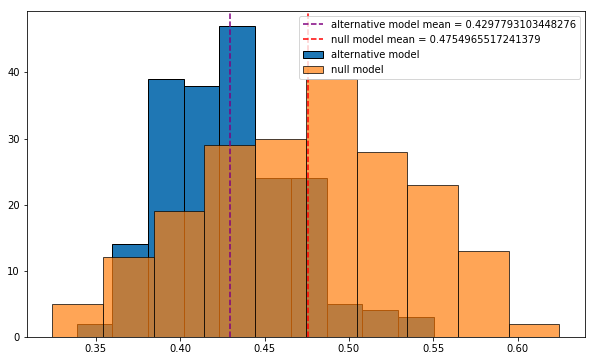

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(rocs, edgecolor="black")
plt.hist(rocs_null, edgecolor="black", alpha=.7)
plt.axvline(rocs.mean(), ls="--", color="purple")
plt.axvline(rocs_null.mean(), ls="--", color="red")
plt.legend(["alternative model mean = {}".format(rocs.mean()),
            "null model mean = {}".format(rocs_null.mean()),
            "alternative model", "null model"])

In [180]:
pvalue = (np.sum(rocs_null >= np.mean(rocs)) + 1.0) / (n_iters + 1.0)
print(pvalue)

0.3333333333333333


# save everything

In [30]:
save_path = "yk_ok_results_with_nullmodel.h5py"

data_obj = dict(
    feat_idx=bools, 
    feat_imp=imps, 
    roc_score=rocs,
    null_feat_idx=bools_null,
    null_feat_imp=imps_null, 
    null_rocs=rocs_null
)

dts = [np.bool, np.float64, np.float64, np.bool, np.float64, np.float64]

print(h5_save(save_path, data_obj, dts))

('yk_ok_results_with_nullmodel.h5py', dict_keys(['feat_idx', 'feat_imp', 'roc_score', 'null_feat_idx', 'null_feat_imp', 'null_rocs']))


# logistic regression model

In [55]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("lg", linear_model.LogisticRegressionCV(
        penalty="l1",
        solver="liblinear",
        cv=LeaveOneOut()
    ))
])

cv_out = LeaveOneOut()
yt, pred = [], []
prednull = []
coefs = []
X = data.values
y = np.copy(behav2g.young_kid.values)

In [49]:
for idx, (train, test) in enumerate(cv_out.split(X, y)):
    # alternative model
    clf.fit(X[train], y[train])
    yt.append(y[test])
    pred.append(clf.predict(X[test]))
    # null model
    yshuff = np.copy(y[train])
    np.random.shuffle(yshuff)
    clf.fit(X[train], yshuff)
    prednull.append(clf.predict(X[test]))

In [50]:
roc_auc_score(np.array(yt).ravel(), np.array(pred).ravel())

0.38363636363636366

In [51]:
roc_auc_score(np.array(yt).ravel(), np.array(prednull).ravel())

0.3927272727272727

# trying recursive feature elimination to make it more similar to the rf models

In [129]:
cv_out = LeaveOneOut()
yt, pred = [], []
feats = []
clf = linear_model.LogisticRegression(penalty="l2")

In [130]:
for train, test in cv_out.split(X, y):
    selector = RFE(clf, 1, step=2)
    selector = selector.fit(X[train], y[train])
    feats.append(data.columns.values[selector.support_])
    X_transformed = selector.transform(X[train])
    clf_transf = linear_model.LogisticRegression()
    clf_transf.fit(X_transformed, y[train])
    yt.append(y[test])
    pred.append(clf_transf.predict(selector.transform(X[test])))

In [131]:
roc_auc_score(np.array(yt).ravel(), np.array(pred).ravel())

0.33636363636363636

In [132]:
Counter(np.array(feats).ravel())

Counter({'ctx_rh_S_temporal_inf.nii.gz': 2,
         'ctx_lh_G_temp_sup-Lateral.nii.gz': 2,
         'ctx_rh_S_temporal_sup.nii.gz': 3,
         'ctx_lh_G_temp_sup-G_T_transv.nii.gz': 21,
         'ctx_lh_S_temporal_transverse.nii.gz': 3,
         'ctx_lh_G_and_S_cingul-Ant.nii.gz': 1,
         'ctx_lh_G_temp_sup-Plan_tempo.nii.gz': 2,
         'ctx_rh_G_temp_sup-G_T_transv.nii.gz': 3,
         'ctx_rh_G_oc-temp_med-Parahip.nii.gz': 1,
         'ctx_lh_G_temporal_inf.nii.gz': 1,
         'Right-Thalamus-Proper.nii.gz': 1,
         'ctx_lh_S_collat_transv_ant.nii.gz': 1,
         'ctx_rh_G_temporal_middle.nii.gz': 1,
         'ctx_rh_Lat_Fis-post.nii.gz': 3,
         'Right-Putamen.nii.gz': 1,
         'Left-Putamen.nii.gz': 1})

# testing the predictive power of the most selected features with rf on the validation set

In [133]:
most_selected = [
    "ctx_lh_S_temporal_transverse.nii.gz",
    "ctx_rh_G_postcentral.nii.gz",
    "ctx_rh_G_precentral.nii.gz",
    "ctx_lh_S_temporal_sup.nii.gz",
    "ctx_lh_S_suborbital.nii.gz"
]

In [136]:
X = vset_data.loc[:, most_selected].values
y = vbehav.young_kid.values

In [137]:
cv = LeaveOneOut()
clf = linear_model.LogisticRegression()
yt = []
pred = []

for train, test in cv.split(X, y):
    clf.fit(X[train], y[train])
    yt.append(y[test])
    pred.append(clf.predict(X[test]))

In [139]:
roc_auc_score(np.array(yt).ravel(), np.array(pred).ravel())

0.5079365079365079

In [145]:
X = vset_data.loc[:, ["ctx_lh_S_suborbital.nii.gz"]].values
y = vbehav.young_kid.values

clf = Pipeline([
    ("sc", StandardScaler()),
    ("lg",linear_model.LogisticRegressionCV(penalty="l2", cv=LeaveOneOut()))
])

In [147]:
clf.fit(data.loc[:, ["ctx_lh_S_suborbital.nii.gz"]], behav2g.young_kid.values)

Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lg', LogisticRegressionCV(Cs=10, class_weight=None, cv=LeaveOneOut(), dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [ ]:
roc_auc_score(y, clf.predict(X))

In [43]:
n_iters = 100 # arbitrary
N, P = data.shape
rocs = np.zeros(n_iters)
rocs_null = np.zeros(n_iters)
bools = np.full((n_iters, N, P), False, dtype=bool)
bools_null = np.full((n_iters, N, P), False, dtype=bool)
imps = np.zeros((n_iters, N, P))
imps_null = np.zeros((n_iters, N, P))
failed_idxs = []


class Storage(object):
    def __init__(self, name, feature_index, feature_importance, _n, _p, feat_elim=False):
        self.name = name
        self.feature_index = feature_index,
        self.feature_importance = feature_importance,
        self._n = _n,
        self._p = _p,
        self.feat_elim = feat_elim
        
    def make_bool_matrix(self):
        if self.feat_elim:
            bool_mat = np.array(
                [self.feature_index[0][i] for 
                i in np.arange(len(self.feature_index[0]))]
            )
        else:
            bool_mat = np.array(self.feature_index).astype(np.bool)
            if len(bool_mat.shape) > 2:
                bool_mat = bool_mat.squeeze()
        return bool_mat
    
    def make_importance_matrix(self):
        bool_mat = self.make_bool_matrix()
        self_feat_imps = np.array(self.feature_importance)
        if len(self_feat_imps.shape) > 2:
            self_feat_imps = self_feat_imps.squeeze()
        if isinstance(self._n, tuple):
                n = self._n[0]
        if isinstance(self._p, tuple):
                p = self._p[0]
        imp_mat = np.zeros((n, p))
        if self.feat_elim:         
            for idx in np.arange(n):
                non_zeros = np.where(bool_mat[idx, :])
                imp_mat[idx, non_zeros] = self_feat_imps[idx]
        else:
            for idx in np.arange(n):
                imp_mat[idx, :] = self_feat_imps[idx]           
        return imp_mat

In [44]:
def random_forest_model_all_features(data, y, cv, clf):
    X = data.values
    results = dict(pred=[], ytrue=[], fi=[], fidx=[])
    results_null = dict(pred=[], ytrue=[], fi=[], fidx=[])
    P = X.shape[1]
    for idx, (train, test) in enumerate(cv.split(X, y)):
        
        clf.fit(X[train], y[train])
        results["pred"].append(clf.predict(X[test]))
        results["ytrue"].append(y[test])
        results["fi"].append(clf.feature_importances_)
        results["fidx"].append(np.arange(P))
    
        # this is to compute the null model
        try:
            y_shuff = np.copy(y[train])
            np.random.shuffle(y_shuff)
            clf.fit(X[train], y_shuff)
            results_null["pred"].append(clf.predict(X[test]))
            results_null["ytrue"].append(y[test])
            results_null["fi"].append(clf.feature_importances_)
            results_null["fidx"].append(np.arange(P))
        except:
            print("couldn't compute null model")
           
    roc = roc_auc_score(np.array(results["ytrue"]).ravel(), np.array(results["pred"]).ravel())
    
    # this is to compute the null model
    try:
        roc_null = roc_auc_score(
            np.array(results_null["ytrue"]).ravel(),
            np.array(results_null["pred"]).ravel()
        )
    except:
        print("couldn't compute null roc score")
        
    return results, roc, results_null, roc_null

In [45]:
def h5_save(path, data_obj, dts):
    if len(data_obj) != len(dts):
        print("something is wrong")
        return None
    with h5py.File(path, "w") as data_store:
        for idx, (key, val) in enumerate(data_obj.items()):
            data_set = data_store.create_dataset(
                key, val.shape, dtype=dts[idx]
            )
            data_set[...] = val
    return path, data_obj.keys()
    
def h5_read(path, key):
    with h5py.File(path, "r") as file_store:
        data = file_store[key][...]
    return data

In [46]:
for idx in np.arange(n_iters):
    clf = RandomForestClassifier(n_estimators=1000) # arbitrary
    cv = LeaveOneOut() # arbitrary
    
    try:
        res, roc, res_null, roc_null = random_forest_model_all_features(
            data.iloc[:, use_idx], behav2g.young_kid.values, cv, clf
        )
        rocs[idx], rocs_null[idx] = roc, roc_null
        s = Storage(
            idx, 
            res["fidx"],
            res["fi"],
            N, 
            P
        )
        s_null = Storage(
            idx,
            res_null["fidx"],
            res_null["fi"],
            N,
            P
        )
        bools[idx, :, :] = s.make_bool_matrix()
        imps[idx, :, :] = s.make_importance_matrix()
        bools_null[idx, :, :] = s_null.make_bool_matrix()
        imps_null[idx, :, :] = s_null.make_importance_matrix()
    except f:
        print(f)
        print(idx)
        failed_idxs.append(idx)
        pass

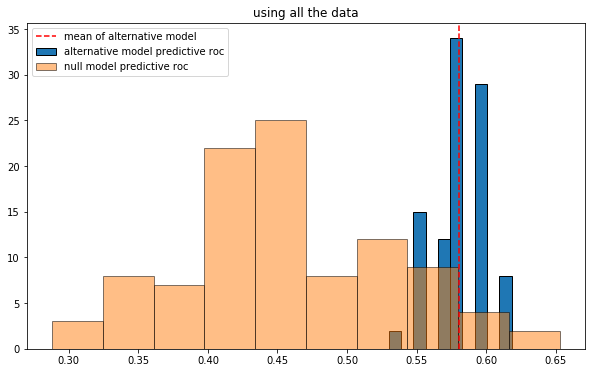

In [67]:
plt.figure(figsize=(10, 6))
plt.hist(rocs, edgecolor="black")
plt.hist(rocs_null, edgecolor="black", alpha=.5)
plt.axvline(np.mean(rocs), color="red", ls="--")
plt.legend(["mean of alternative model", "alternative model predictive roc", 
            "null model predictive roc"])
plt.title("using all the data")
plt.savefig("alldata_rf_model.png", dpi=300)

In [90]:
print("pvalue: {}".format((np.sum(rocs_null >= np.mean(rocs)) + 1 )/(101)))

pvalue: 0.06930693069306931


In [87]:
impdf = pd.DataFrame(
    data=np.vstack((imps.mean(0).sum(0), data.columns.values)).T,
    columns=["summary importances","features"]
)

In [88]:
impdf

,summary importances,features
0,0.748707,ctx_lh_S_temporal_inf.nii.gz
1,0.595891,Right-Thalamus-Proper.nii.gz
2,0.970142,ctx_lh_G_temp_sup-G_T_transv.nii.gz
3,1.01363,ctx_rh_S_orbital-H_Shaped.nii.gz
4,0.520917,Left-Accumbens-area.nii.gz
5,0.557776,ctx_rh_G_oc-temp_med-Parahip.nii.gz
6,0.585878,Right-Accumbens-area.nii.gz
7,0.610969,ctx_rh_G_temp_sup-Lateral.nii.gz
8,0.515651,ctx_rh_S_temporal_transverse.nii.gz
9,0.435165,Right-Caudate.nii.gz


In [91]:
save_path = "yk_ad_results_with_nullmodel.h5py"

data_obj = dict(
    feat_idx=bools, 
    feat_imp=imps, 
    roc_score=rocs,
    null_feat_idx=bools_null,
    null_feat_imp=imps_null, 
    null_rocs=rocs_null
)

dts = [np.bool, np.float64, np.float64, np.bool, np.float64, np.float64]

print(h5_save(save_path, data_obj, dts))

('yk_ad_results_with_nullmodel.h5py', dict_keys(['feat_idx', 'feat_imp', 'roc_score', 'null_feat_idx', 'null_feat_imp', 'null_rocs']))
